# New model

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Load and preprocessing data

In [2]:
def load_and_preprocess_data():
    """Load data with improved preprocessing"""
    try:
        X_train = np.loadtxt('input.csv', delimiter=',')
        X_test = np.loadtxt('input_test.csv', delimiter=',')
        Y_train = np.loadtxt('labels.csv', delimiter=',')
        Y_test = np.loadtxt('labels_test.csv', delimiter=',')
    except ValueError:
        import pandas as pd
        X_train = pd.read_csv('input.csv').to_numpy()
        X_test = pd.read_csv('input_test.csv').to_numpy()
        Y_train = pd.read_csv('labels.csv').to_numpy()
        Y_test = pd.read_csv('labels_test.csv').to_numpy()
    
    # Reshape data
    X_train = X_train.reshape(-1, 100, 100, 3)
    X_test = X_test.reshape(-1, 100, 100, 3)
    Y_train = Y_train.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    
    # Normalize pixel values
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Per-channel normalization 
    # Compute mean and std per channel on training data
    train_mean = np.mean(X_train, axis=(0, 1, 2))
    train_std = np.std(X_train, axis=(0, 1, 2))
    
    # Apply normalization
    X_train = (X_train - train_mean) / (train_std + 1e-7)
    X_test = (X_test - train_mean) / (train_std + 1e-7)
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training labels distribution: {np.bincount(Y_train.astype(int).flatten())}")
    
    return X_train, X_test, Y_train, Y_test

# data augmentatio

In [3]:
def create_data_generators(X_train, Y_train, X_test, Y_test):
    """Create data generators with more aggressive augmentation"""
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        zoom_range=0.3,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # No augmentation for validation data
    val_datagen = ImageDataGenerator()
    
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
    val_generator = val_datagen.flow(X_test, Y_test, batch_size=32, shuffle=False)
    
    return train_generator, val_generator


# CNN architecture

In [4]:
def create_improved_model():
    """Create an improved CNN model with better architecture"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Global Average Pooling instead of Flatten
        GlobalAveragePooling2D(),
        
        # Dense layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model


# Transfer learning model (VGG16-based)

In [5]:
def create_transfer_learning_model():
    """Create a transfer learning model using VGG16"""
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.models import Model
    
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    
    # Freeze early layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Add custom classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Training 

In [6]:
def train_model(model, train_generator, val_generator, model_name="enhanced_model"):
    """Train the model with advanced callbacks"""
    
    # Compile with optimized parameters
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Advanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,  # More epochs with early stopping
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    return history


# Evaluation and visualization

In [7]:
def evaluate_and_visualize(model, X_test, Y_test):
    """Comprehensive model evaluation"""
    
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred.flatten() == Y_test.flatten())
    print(f"Final Test Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dog', 'Cat'], yticklabels=['Dog', 'Cat'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Enhanced Model')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(Y_test, y_pred, target_names=['Dog', 'Cat']))
    
    return accuracy


# Ensemble method

In [8]:
def create_ensemble_prediction(models, X_test):
    """Create ensemble predictions from multiple models"""
    predictions = []
    
    for model in models:
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return (ensemble_pred > 0.5).astype(int)

# Main execution function
def main():
    """Main function to run the entire pipeline"""
    
    print("="*50)
    print("ENHANCED DOG VS CAT CLASSIFICATION")
    print("="*50)
    
    # Step 1: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    X_train, X_test, Y_train, Y_test = load_and_preprocess_data()
    
    # Step 2: Create data generators
    print("\n2. Creating data generators...")
    train_gen, val_gen = create_data_generators(X_train, Y_train, X_test, Y_test)
    
    # Step 3: Train improved CNN model
    print("\n3. Training improved CNN model...")
    improved_model = create_improved_model()
    print(f"Model parameters: {improved_model.count_params():,}")
    
    history1 = train_model(improved_model, train_gen, val_gen, "improved_cnn")
    acc1 = evaluate_and_visualize(improved_model, X_test, Y_test)
    
    # Step 4: Train transfer learning model
    print("\n4. Training transfer learning model...")
    transfer_model = create_transfer_learning_model()
    print(f"Transfer model parameters: {transfer_model.count_params():,}")
    
    # Recreate generators for transfer learning
    train_gen2, val_gen2 = create_data_generators(X_train, Y_train, X_test, Y_test)
    history2 = train_model(transfer_model, train_gen2, val_gen2, "transfer_learning")
    acc2 = evaluate_and_visualize(transfer_model, X_test, Y_test)
    

# prediction

In [9]:
def create_ensemble_prediction(models, X_test):
    """Create ensemble predictions from multiple models"""
    predictions = []
    
    for model in models:
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return (ensemble_pred > 0.5).astype(int)

# Main execution function
def main():
    """Main function to run the entire pipeline"""
    
    print("="*50)
    print("ENHANCED DOG VS CAT CLASSIFICATION")
    print("="*50)
    
    # Step 1: Load and preprocess data
    print("\n1. Loading and preprocessing data...")
    X_train, X_test, Y_train, Y_test = load_and_preprocess_data()
    
    # Step 2: Create data generators
    print("\n2. Creating data generators...")
    train_gen, val_gen = create_data_generators(X_train, Y_train, X_test, Y_test)
    
    # Step 3: Train improved CNN model
    print("\n3. Training improved CNN model...")
    improved_model = create_improved_model()
    print(f"Model parameters: {improved_model.count_params():,}")
    
    history1 = train_model(improved_model, train_gen, val_gen, "improved_cnn")
    acc1 = evaluate_and_visualize(improved_model, X_test, Y_test)
    
    # Step 4: Train transfer learning model
    print("\n4. Training transfer learning model...")
    transfer_model = create_transfer_learning_model()
    print(f"Transfer model parameters: {transfer_model.count_params():,}")
    
    # Recreate generators for transfer learning
    train_gen2, val_gen2 = create_data_generators(X_train, Y_train, X_test, Y_test)
    history2 = train_model(transfer_model, train_gen2, val_gen2, "transfer_learning")
    acc2 = evaluate_and_visualize(transfer_model, X_test, Y_test)
    
    # Step 5: Ensemble prediction
    print("\n5. Creating ensemble prediction...")
    ensemble_pred = create_ensemble_prediction([improved_model, transfer_model], X_test)
    ensemble_acc = np.mean(ensemble_pred.flatten() == Y_test.flatten())
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    
    # Final comparison
    print("\n" + "="*50)
    print("FINAL RESULTS COMPARISON:")
    print("="*50)
    print(f"Improved CNN Accuracy: {acc1:.4f}")
    print(f"Transfer Learning Accuracy: {acc2:.4f}")
    print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
    print("="*50)
    
    return improved_model, transfer_model, ensemble_acc

# Additional utility functions
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def show_prediction_examples(model, X_test, Y_test, num_examples=8):
    """Show prediction examples"""
    indices = np.random.choice(len(X_test), num_examples, replace=False)
    
    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i+1)
        
        # Denormalize image for display (if normalized)
        img = X_test[idx]
        if img.min() < 0:  # If normalized
            img = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        
        pred_prob = model.predict(np.expand_dims(X_test[idx], axis=0))[0][0]
        pred_class = "Cat" if pred_prob > 0.5 else "Dog"
        true_class = "Cat" if Y_test[idx][0] > 0.5 else "Dog"
        
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class} ({pred_prob:.2f})', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main

ENHANCED DOG VS CAT CLASSIFICATION

1. Loading and preprocessing data...
Training data shape: (2000, 100, 100, 3)
Test data shape: (400, 100, 100, 3)
Training labels distribution: [1000 1000]

2. Creating data generators...

3. Training improved CNN model...


/home/anubhav_jha/tf-gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755413060.123641    1569 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model parameters: 849,313
Epoch 1/100


/home/anubhav_jha/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-17 06:44:26.122483: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ee324005ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-17 06:44:26.122528: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-17 06:44:26.282538: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-17 06:44:27.194399: I external/local_xla/xla/stream_executor/cud

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5141 - loss: 1.0847
Epoch 1: val_accuracy improved from None to 0.51500, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.5280 - loss: 1.0446 - val_accuracy: 0.5150 - val_loss: 0.7073 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5330 - loss: 1.0280
Epoch 2: val_accuracy improved from 0.51500 to 0.54500, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5210 - loss: 1.0037 - val_accuracy: 0.5450 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5271 - loss: 0.9343
Epoch 3: val_accuracy improved from 0.54500 to 0.56250, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5255 - loss: 0.9163 - val_accuracy: 0.5625 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5376 - loss: 0.8514
Epoch 4: val_accuracy did not improve from 0.56250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5325 - loss: 0.8531 - val_accuracy: 0.5250 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5788 - loss: 0.7773
Epoch 5: val_accuracy did not improve from 0.56250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5625 - loss: 0.7831 - val_accuracy: 0.5225 - val_loss: 0.7354 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5516 - loss: 0.7570
Epoch 6: val_accuracy improved from 0.56250 to 0.62000, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5515 - loss: 0.7508 - val_accuracy: 0.6200 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5418 - loss: 0.7837
Epoch 7: val_accuracy did not improve from 0.62000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5485 - loss: 0.7628 - val_accuracy: 0.6150 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5473 - loss: 0.7275
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_accuracy did not improve from 0.62000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5580 - loss: 0.7324 - val_accuracy: 0.5750 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5767 - loss: 0.7063
Epoch 9: val_accuracy did not improve from 0.62000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5965 - loss: 0.6960 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5970 - loss: 0.6937 - val_accuracy: 0.6725 - val_loss: 0.6038 - learning_rate: 5.0000e-04
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6153 - loss: 0.6596
Epoch 11: val_accuracy did not improve from 0.67250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6090 - loss: 0.6652 - val_accuracy: 0.6150 - val_loss: 0.6342 - learning_rate: 5.0000e-04
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6132 - loss: 0.6614
Epoch 12: val_accuracy did not improve from 0.67250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6070 - loss: 0.6675 - val_accuracy: 0.6175 - val_loss: 0.6266 - learning_rate: 5.0000e-04
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5985 - loss: 0.6843
Epoch 13: val_accuracy did not improve from 0.67250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6130 - loss: 0.6690 - val_accuracy: 0.6600 - val_loss: 0.6142 - learning_rate: 5.0000e-04
Epoch 1

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6125 - loss: 0.6570 - val_accuracy: 0.6750 - val_loss: 0.6163 - learning_rate: 5.0000e-04
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6097 - loss: 0.6649
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_accuracy improved from 0.67500 to 0.68750, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6205 - loss: 0.6684 - val_accuracy: 0.6875 - val_loss: 0.6076 - learning_rate: 5.0000e-04
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6343 - loss: 0.6456
Epoch 16: val_accuracy did not improve from 0.68750
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6465 - loss: 0.6359 - val_accuracy: 0.6800 - val_loss: 0.5899 - learning_rate: 2.5000e-04
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6437 - loss: 0.6364
Epoch 17: val_accuracy improved from 0.68750 to 0.69500, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6295 - loss: 0.6430 - val_accuracy: 0.6950 - val_loss: 0.5808 - learning_rate: 2.5000e-04
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6715 - loss: 0.6271
Epoch 18: val_accuracy improved from 0.69500 to 0.71500, saving model to improved_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6565 - loss: 0.6364 - val_accuracy: 0.7150 - val_loss: 0.5695 - learning_rate: 2.5000e-04
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6433 - loss: 0.6340
Epoch 19: val_accuracy did not improve from 0.71500
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6635 - loss: 0.6245 - val_accuracy: 0.6150 - val_loss: 0.6446 - learning_rate: 2.5000e-04
Epoch 20/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6511 - loss: 0.6190
Epoch 20: val_accuracy did not improve from 0.71500
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6420 - loss: 0.6374 - val_accuracy: 0.6850 - val_loss: 0.5864 - learning_rate: 2.5000e-04
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6605 - loss: 0.6190
Epoch 21: val_accuracy did not improve from 0.71500
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6485 - loss: 0.6277 - val_accuracy: 0.6925 - val_loss: 0.5828 - learning_rate: 2.5000e-04
Epoch 2

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6675 - loss: 0.6111 - val_accuracy: 0.7250 - val_loss: 0.5737 - learning_rate: 2.5000e-04
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6656 - loss: 0.6007
Epoch 24: val_accuracy did not improve from 0.72500
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6745 - loss: 0.6014 - val_accuracy: 0.6825 - val_loss: 0.5851 - learning_rate: 2.5000e-04
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6686 - loss: 0.5974
Epoch 25: val_accuracy did not improve from 0.72500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6735 - loss: 0.6019 - val_accuracy: 0.6500 - val_loss: 0.6190 - learning_rate: 2.5000e-04
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6661 - loss: 0.5999
Epoch 26: val_accuracy did not improve from 0.72500
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6725 - loss: 0.5991 - val_accuracy: 0.6700 - val_loss: 0.6109 - learning_rate: 2.5000e-04
Epoch 2

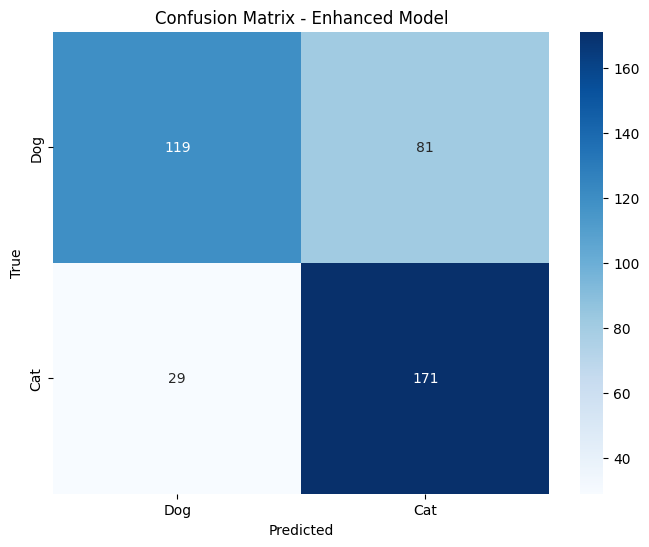


Classification Report:
              precision    recall  f1-score   support

         Dog       0.80      0.59      0.68       200
         Cat       0.68      0.85      0.76       200

    accuracy                           0.72       400
   macro avg       0.74      0.72      0.72       400
weighted avg       0.74      0.72      0.72       400


4. Training transfer learning model...
Transfer model parameters: 15,110,977
Epoch 1/100


/home/anubhav_jha/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-17 06:47:34.157165: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-17 06:47:34.849310: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2304', 16 bytes spill stores, 16 bytes spill loads

2025-08-17 06:47:35.106929: I external/local_xla/xla/s

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6097 - loss: 0.8046
Epoch 1: val_accuracy improved from None to 0.64000, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.6850 - loss: 0.6608 - val_accuracy: 0.6400 - val_loss: 2.2455 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7949 - loss: 0.4413
Epoch 2: val_accuracy improved from 0.64000 to 0.81250, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8115 - loss: 0.4310 - val_accuracy: 0.8125 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8304 - loss: 0.3824
Epoch 3: val_accuracy did not improve from 0.81250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8310 - loss: 0.3883 - val_accuracy: 0.5100 - val_loss: 2.0651 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8655 - loss: 0.3551
Epoch 4: val_accuracy did not improve from 0.81250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8595 - loss: 0.3600 - val_accuracy: 0.5225 - val_loss: 2.3634 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8707 - loss: 0.3191
Epoch 5: val_accuracy did not improve from 0.81250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8665 - loss: 0.3322 - val_accuracy: 0.5725 - val_loss: 1.7038 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8800 - loss: 0.2962 - val_accuracy: 0.8250 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8894 - loss: 0.2709
Epoch 8: val_accuracy improved from 0.82500 to 0.88500, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8890 - loss: 0.2747 - val_accuracy: 0.8850 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8835 - loss: 0.2848
Epoch 9: val_accuracy improved from 0.88500 to 0.91500, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8860 - loss: 0.2781 - val_accuracy: 0.9150 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8814 - loss: 0.2939
Epoch 10: val_accuracy did not improve from 0.91500
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8810 - loss: 0.2900 - val_accuracy: 0.8550 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8855 - loss: 0.2718
Epoch 11: val_accuracy improved from 0.91500 to 0.92750, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8845 - loss: 0.2748 - val_accuracy: 0.9275 - val_loss: 0.1778 - learning_rate: 0.0010
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8842 - loss: 0.2561
Epoch 12: val_accuracy improved from 0.92750 to 0.93000, saving model to transfer_learning_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8925 - loss: 0.2385 - val_accuracy: 0.9300 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9052 - loss: 0.2284
Epoch 13: val_accuracy did not improve from 0.93000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8990 - loss: 0.2415 - val_accuracy: 0.7200 - val_loss: 1.3950 - learning_rate: 0.0010
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9069 - loss: 0.2256
Epoch 14: val_accuracy did not improve from 0.93000
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9025 - loss: 0.2435 - val_accuracy: 0.9150 - val_loss: 0.1956 - learning_rate: 0.0010
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9257 - loss: 0.1873
Epoch 15: val_accuracy did not improve from 0.93000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9115 - loss: 0.2160 - val_accuracy: 0.8500 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 16/100
63/63 ━━━━

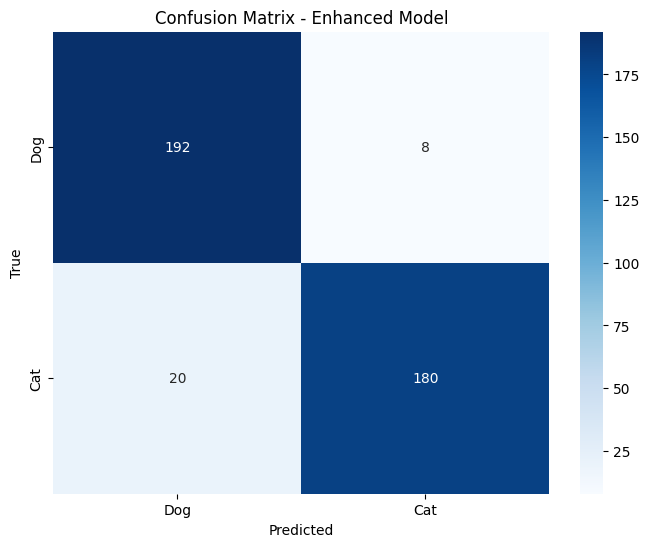


Classification Report:
              precision    recall  f1-score   support

         Dog       0.91      0.96      0.93       200
         Cat       0.96      0.90      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400


5. Creating ensemble prediction...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Ensemble Accuracy: 0.9375

FINAL RESULTS COMPARISON:
Improved CNN Accuracy: 0.7250
Transfer Learning Accuracy: 0.9300
Ensemble Accuracy: 0.9375


In [10]:
if __name__ == "__main__":
    improved_model, transfer_model, final_accuracy = main()

In [15]:
# Run this BEFORE running the ModelTester
X_train, X_test, Y_train, Y_test = load_and_preprocess_data()



Training data shape: (2000, 100, 100, 3)
Test data shape: (400, 100, 100, 3)
Training labels distribution: [1000 1000]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Tuple, Optional, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ModelTester:
    """
    A professional model testing suite for binary classification tasks.
    Provides clean visualization and comprehensive testing capabilities.
    """
    
    def __init__(self, model=None, X_test=None, Y_test=None):
        """
        Initialize the ModelTester with model and test data.
        
        Args:
            model: Trained model with predict method
            X_test: Test images array
            Y_test: Test labels array
        """
        self.model = model
        self.X_test = X_test
        self.Y_test = Y_test
        self.class_names = ["Dog", "Cat"]  # 0: Dog, 1: Cat
        
    def _validate_inputs(self) -> bool:
        """Validate that model and test data are available."""
        if self.model is None:
            print("Model not provided. Please load or train a model first.")
            return False
            
        if self.X_test is None or self.Y_test is None:
            print("Test data not provided. Please load X_test and Y_test.")
            return False
            
        if len(self.X_test) == 0:
            print("Test dataset is empty.")
            return False
            
        return True
    
    def _preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess image for display.
        
        Args:
            image: Raw image array
            
        Returns:
            Preprocessed image suitable for display
        """
        processed_image = image.copy()
        
        # Normalize to [0, 1] range if needed
        if processed_image.min() < 0 or processed_image.max() > 1:
            processed_image = (processed_image - processed_image.min()) / \
                            (processed_image.max() - processed_image.min())
        
        return processed_image
    
    def _get_prediction_info(self, prediction_score: float, actual_label: float) -> dict:
        """
        Process prediction and actual labels to get class information.
        
        Args:
            prediction_score: Raw prediction score from model
            actual_label: Actual label
            
        Returns:
            Dictionary containing prediction information
        """
        # Determine predicted class
        predicted_class_idx = 1 if prediction_score > 0.5 else 0
        predicted_class = self.class_names[predicted_class_idx]
        confidence = prediction_score if prediction_score > 0.5 else (1 - prediction_score)
        
        # Determine actual class
        actual_class_idx = 1 if actual_label > 0.5 else 0
        actual_class = self.class_names[actual_class_idx]
        
        # Check if prediction is correct
        is_correct = predicted_class == actual_class
        
        return {
            'predicted_class': predicted_class,
            'actual_class': actual_class,
            'confidence': confidence,
            'is_correct': is_correct,
            'raw_score': prediction_score,
            'predicted_class_idx': predicted_class_idx,
            'actual_class_idx': actual_class_idx
        }
    
    def test_single_prediction(self, idx: Optional[int] = None, show_plot: bool = True) -> dict:
        """
        Test model prediction on a single random image.
        
        Args:
            idx: Specific index to test (if None, random index is selected)
            show_plot: Whether to display the visualization
            
        Returns:
            Dictionary containing test results
        """
        if not self._validate_inputs():
            return None
            
        # Select random index if not provided
        if idx is None:
            idx = random.randint(0, len(self.X_test) - 1)
        elif idx >= len(self.X_test):
            print(f"Index {idx} is out of range. Dataset has {len(self.X_test)} samples.")
            return None
        
        # Get image and preprocess
        test_image = self._preprocess_image(self.X_test[idx])
        
        # Make prediction
        try:
            prediction_score = self.model.predict(self.X_test[idx:idx+1], verbose=0)[0][0]
            actual_label = self.Y_test[idx][0] if len(self.Y_test[idx].shape) > 0 else self.Y_test[idx]
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None
        
        # Process prediction information
        pred_info = self._get_prediction_info(prediction_score, actual_label)
        
        # Display results
        if show_plot:
            self._display_prediction(test_image, pred_info, idx)
        
        # Don't log to console, just return the dictionary
        result = {
            'sample_index': idx,
            'is_correct': pred_info['is_correct'],
            'predicted_class': pred_info['predicted_class'],
            'actual_class': pred_info['actual_class'],
            'confidence': pred_info['confidence'],
            'raw_score': pred_info['raw_score']
        }
        
        # Print the dictionary in a clean format
        print(result)
        
        return result
    
    def _display_prediction(self, image: np.ndarray, pred_info: dict, idx: int):
        """
        Display only the image without results panel.
        
        Args:
            image: Preprocessed image
            pred_info: Prediction information dictionary
            idx: Sample index
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(f"Test Sample #{idx}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def batch_test(self, num_tests: int = 5, show_individual: bool = False) -> dict:
        """
        Run multiple random tests and provide summary statistics.
        
        Args:
            num_tests: Number of tests to run
            show_individual: Whether to show individual test visualizations
            
        Returns:
            Dictionary containing batch test results
        """
        if not self._validate_inputs():
            return None
            
        logger.info(f"Running batch test on {num_tests} random samples...")
        
        results = []
        correct_count = 0
        
        for i in range(num_tests):
            logger.info(f"Test {i+1}/{num_tests}")
            result = self.test_single_prediction(show_plot=show_individual)
            
            if result:
                results.append(result)
                if result['is_correct']:
                    correct_count += 1
        
        # Calculate statistics
        accuracy = correct_count / len(results) if results else 0
        
        # Display summary
        self._display_batch_summary(results, accuracy)
        
        return {
            'total_tests': len(results),
            'correct_predictions': correct_count,
            'accuracy': accuracy,
            'individual_results': results
        }
    
    def _display_batch_summary(self, results: list, accuracy: float):
        """Display batch test summary."""
        print("\n" + "="*60)
        print("BATCH TEST SUMMARY")
        print("="*60)
        print(f"Total Tests:        {len(results)}")
        print(f"Correct Predictions: {sum(r['is_correct'] for r in results)}")
        print(f"Accuracy:           {accuracy:.1%}")
        print("="*60)
        
        # Show breakdown by class if available
        if results:
            actual_classes = [r['actual_class'] for r in results]
            for class_name in self.class_names:
                class_results = [r for r in results if r['actual_class'] == class_name]
                if class_results:
                    class_accuracy = sum(r['is_correct'] for r in class_results) / len(class_results)
                    print(f"{class_name} Accuracy:     {class_accuracy:.1%} ({sum(r['is_correct'] for r in class_results)}/{len(class_results)})")
        print("="*60)

    @staticmethod
    def auto_detect_and_test(globals_dict: dict, num_tests: int = 1):
        """
        Automatically detect available models and test data, then run tests.
        
        Args:
            globals_dict: Global variables dictionary (pass globals())
            num_tests: Number of tests to run
        """
        # Try to detect model
        model_candidates = ['transfer_model', 'improved_model', 'best_model', 'model']
        model = None
        model_name = None
        
        for name in model_candidates:
            if name in globals_dict and globals_dict[name] is not None:
                model = globals_dict[name]
                model_name = name
                break
        
        # Try to detect test data
        X_test = globals_dict.get('X_test')
        Y_test = globals_dict.get('Y_test')
        
        # If test data not found, try to load it using available function
        if X_test is None or Y_test is None:
            if 'load_and_preprocess_data' in globals_dict:
                print("Loading data...")
                try:
                    X_train, X_test, Y_train, Y_test = globals_dict['load_and_preprocess_data']()
                    print("Data loaded successfully!")
                    # Store in global scope for future use
                    globals_dict['X_train'] = X_train
                    globals_dict['X_test'] = X_test
                    globals_dict['Y_train'] = Y_train
                    globals_dict['Y_test'] = Y_test
                except Exception as e:
                    print(f"Failed to load data: {e}")
                    return None
            else:
                print("Test data (X_test, Y_test) not found in global scope.")
                print("Please run: X_train, X_test, Y_train, Y_test = load_and_preprocess_data()")
                return None
        
        if model is None:
            print("No model detected. Available model names: " + 
                        ", ".join(model_candidates))
            print("Please ensure your model is stored in one of these variable names.")
            return None
        
        print(f"Using model: {model_name}")
        print(f"Test dataset: {len(X_test)} samples")
        
        # Create tester and run tests
        tester = ModelTester(model, X_test, Y_test)
        
        if num_tests == 1:
            return tester.test_single_prediction()
        else:
            return tester.batch_test(num_tests)


# =============================================================================
# USAGE EXAMPLES
# =============================================================================

def main():
    """Main function demonstrating usage."""
    print("Professional Model Testing Suite")
    print("="*50)
    
    # Method 1: Auto-detection (recommended)
    print("\n1. Auto-detecting model and test data...")
    ModelTester.auto_detect_and_test(globals(), num_tests=1)
    
    # Method 2: Manual initialization (if auto-detection fails)
    # Uncomment and modify as needed:
    """
    if 'your_model' in globals() and 'X_test' in globals() and 'Y_test' in globals():
        tester = ModelTester(your_model, X_test, Y_test)
        
        # Single test
        tester.test_single_prediction()
        
        # Batch test
        # tester.batch_test(num_tests=5)
    """

Using model: transfer_model
Test dataset: 400 samples


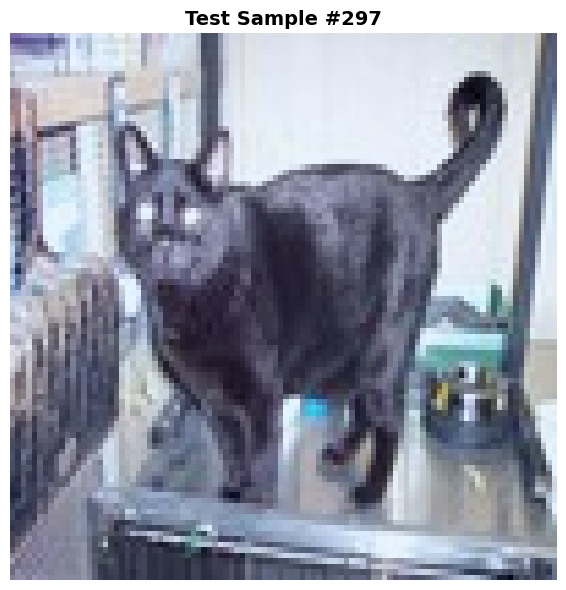

{'sample_index': 297, 'is_correct': True, 'predicted_class': 'Cat', 'actual_class': 'Cat', 'confidence': np.float32(0.98889214), 'raw_score': np.float32(0.98889214)}


{'sample_index': 297,
 'is_correct': True,
 'predicted_class': 'Cat',
 'actual_class': 'Cat',
 'confidence': np.float32(0.98889214),
 'raw_score': np.float32(0.98889214)}

In [40]:

ModelTester.auto_detect_and_test(globals(), num_tests=1)